# Covid Zip Code Analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
df = pd.read_pickle(r'complete_df.pickle')

In [26]:
df.head()

,ZCTA,totalPop,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist,2weeksprior,testpercent,posRate,percent_change_pos_rate
0,60601,14675.0,34.9,103243.0,1.655573,0.086814,0.055741,0.741670,0.239387,0.035434,0.029972,0.040341,0.083543,0.145963,0.002052,0.037657,0.077888,0.054243,0.016586
1,60602,1244.0,30.6,157125.0,2.066445,0.065113,0.037781,0.681672,0.117363,0.047428,0.008842,0.000804,0.126206,0.245981,0.004248,0.065421,0.083601,0.048077,-0.017344
2,60603,1174.0,28.9,151765.0,2.081560,0.097956,0.032368,0.634583,0.160136,0.000000,0.069847,0.055366,0.080068,0.231687,0.005119,0.034483,0.061329,0.041667,0.007184
3,60604,782.0,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123,0.026667,0.084399,0.090909,0.064242
4,60605,27519.0,33.9,111164.0,1.984782,0.058432,0.171772,0.612050,0.103601,0.013700,0.026408,0.025146,0.101821,0.252516,0.008169,0.033480,0.086231,0.063211,0.029731


In [27]:
testing_rate = df.testpercent
positivity_rate = df.posRate
features = df.iloc[:,2:-4]

In [28]:
features.head()

,medianAge,medianHHInc,mean_HHsize,pctHispanic,pctBlack,pctWhite,pctUndocumented,pctUndocumentedFBLA,pctUninsured,pctUnemployed,pctHealthWorkers,pctEssential,dist
0,34.9,103243.0,1.655573,0.086814,0.055741,0.741670,0.239387,0.035434,0.029972,0.040341,0.083543,0.145963,0.002052
1,30.6,157125.0,2.066445,0.065113,0.037781,0.681672,0.117363,0.047428,0.008842,0.000804,0.126206,0.245981,0.004248
2,28.9,151765.0,2.081560,0.097956,0.032368,0.634583,0.160136,0.000000,0.069847,0.055366,0.080068,0.231687,0.005119
3,32.4,116250.0,1.632568,0.043478,0.056266,0.634271,0.162404,0.008951,0.003836,0.057545,0.067775,0.125320,0.008123
4,33.9,111164.0,1.984782,0.058432,0.171772,0.612050,0.103601,0.013700,0.026408,0.025146,0.101821,0.252516,0.008169


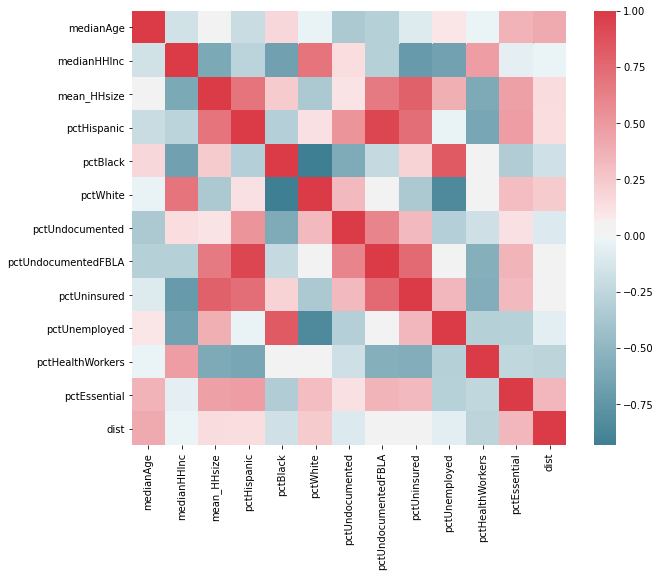

In [29]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In the above correlation matrix, we can see that the following are highly correlated with one another:
- Percent White & Percent Black (-)
- Percent White & Percent Unemployed (-)
- Percent Hispanic & Percent Undocumented FBLA (Foreign Born Latin America) (+)
- Percent Black & Percent Unemployed (+)
- Percent Uninsured & Mean HH Size (+)
- Median Income & Percent Unisured (-)

In the below regression analyses, I will run each regression using all variables, first, and then remove those that are not significant at the 10 percent confidence level (p>0.1).

## Exploring the relationship between each feature and positivity rates in a Zip Code

In [30]:
# Run an OLS regression to determine which variables are most correlated with ridership
import statsmodels.api as sm

X = sm.add_constant(features)
y = positivity_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                posRate   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     14.84
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           1.01e-11
Time:                        21:02:51   Log-Likelihood:                 151.16
No. Observations:                  56   AIC:                            -274.3
Df Residuals:                      42   BIC:                            -246.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0432    

In [35]:
# re-running the regression with only significant features (p<0.05)
X = sm.add_constant(features[['pctHispanic', 'pctHealthWorkers', 'pctEssential']])
y = positivity_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                posRate   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     43.50
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           3.30e-14
Time:                        21:08:12   Log-Likelihood:                 138.11
No. Observations:                  56   AIC:                            -268.2
Df Residuals:                      52   BIC:                            -260.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0684      0.024  

### Positivity Rates Analysis
The above output tables show that only five features in the dataset are robust - **Percent Hispanic, Percent Healthcare Workers, and Percent Essential Workers**. That is to say that these three features are significantly correlated with a ZIP code's 2-week average positivity rate controlling for the other variables.

#### Interpretation:
- A one-percentage_point increase in **percent Hispanic** is expected to increase an area's positivity rate by 7.9 percentage points. 
- A one-percentage point increase in an area's **composition of healthcare workers** is expected to result in an 80 percentage point decrease in COVID-19 positivity rates. I'm unsure of why this might be the case. It may be a result of noise in the model, or it may mean that healthcare workers get tested at their jobs.
- A one percentage-point increase in a zip code's **percentage of essential workers** is estimated to be associated with a 23.7 percentage-point increase in Covid positivity rates.

#### R-Squared Value: 
An R-Squared value of 71.5 percent would indicate that the features included in this model account for 71.5 percent of the variation in positivity rates. This is a faily high value for an R-squared term meaning that each. of these three features carries substantial weight in zip-code-level positivity rates.

## Exploring the relationship between each feature and testing

In [38]:
# Run an OLS regression to determine which variables are most correlated with ridership

X = sm.add_constant(features)
y = testing_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            testpercent   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     4.281
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           0.000158
Time:                        21:11:48   Log-Likelihood:                 152.76
No. Observations:                  56   AIC:                            -277.5
Df Residuals:                      42   BIC:                            -249.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3000    

In [39]:
# re-running the regression with only significant features (p<0.05)
X = sm.add_constant(features[['medianAge', 'medianHHInc', 'pctUninsured']])
y = testing_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            testpercent   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     13.30
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           1.46e-06
Time:                        21:12:32   Log-Likelihood:                 145.08
No. Observations:                  56   AIC:                            -282.2
Df Residuals:                      52   BIC:                            -274.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2004      0.032      6.213   

In [40]:
# re-running the regression with only significant features (p<0.05)
X = sm.add_constant(features[['medianAge', 'pctUninsured']])
y = testing_rate

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            testpercent   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     19.71
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           4.00e-07
Time:                        21:13:09   Log-Likelihood:                 144.70
No. Observations:                  56   AIC:                            -283.4
Df Residuals:                      53   BIC:                            -277.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1827      0.024      7.491   

### Testing Rates Analysis
The above output tables show that only one feature in the dataset is robust - **Median Age and Percent Uninsured**. That is to say that these two features are significantly negatively correlated with a zip code's percentage of residents who get tested.

#### Interpretation:
- A one-year increase in a zip code's **median age** is associated with an expected 0.25 percentage point decrease in an area's total positivity rate. This is likely due to the high rates of testing in college neighborhoods such as Hyde Park, West Loop, Lincoln Park and Rogers Park.
- A one-percentage point increase in an area's **percentage of uninsured individuals** is associated with an expected 27.4 percentage-point decrease in the area's positivity rates. This could imply that individuals who are uninsured may not be aware that testing is readily available at no cost.

#### R-Squared Value:
An R-Squared value of 42.6 percent is relatively low for this analysis. It implies that median age and percent uninsured account for roughly 42.6 percent of the variation in testing per capita. This means that there are additional features (not included in this model) that could be having a large effect on testing per capita. Future analyses could incorporate additional features such as presence of a college/university.
